In [121]:
# imports
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, auc, precision_recall_curve


In [93]:
# training df 
df_train = pd.read_csv('../../data/train/customer_churn_dataset-training-master.csv')
# drop nulls
df_train.dropna(axis=0, inplace=True)
# dtypes to int
df_train = df_train.astype({'CustomerID':'int', 'Age': 'int', 'Tenure':'int', 'Usage Frequency':'int', 'Support Calls':'int', 'Total Spend':'int', 'Last Interaction':'int',  'Churn':'int'})
# remove index (ID col)
df_train.drop(columns='CustomerID', inplace=True)
#columns to numeric
df_train['Gender'] = df_train['Gender'].map({'Male': 1, 'Female':0});
df_train['Subscription Type'] = df_train['Subscription Type'].map({'Basic':1, 'Standard':2,'Premium': 3})
df_train['Contract Length'] = df_train['Contract Length'].map({'Monthly':1, 'Quarterly':3,'Annual':12 })
#reorder cols 
columns = [col for col in df_train.columns if col != 'Churn'] + ['Churn']
df_train = df_train[columns]
#normalise column names 
df_train.rename(columns={'Age': 'age' , 'Gender': 'gender', 'Tenure': 'tenure', 'Usage Frequency': 'usage_frequency', 
                 'Support Calls':'support_calls', 'Payment Delay': 'payment_delay', 'Contract Length': 'contract_length', 
                 'Total Spend':'total_spend', 'Last Interaction': 'last_interaction', 'Subscription Type': 'subscription_type',
                 'Churn':'churn'}, inplace=True)

In [75]:
#test df 
df_test = pd.read_csv('../../data/test/customer_churn_dataset-testing-master.csv')
# drop nulls
df_test.dropna(axis=0, inplace=True)
# remove index (ID col)
df_test.drop(columns='CustomerID', inplace=True)
# dtypes to int
df_test = df_test.astype({'Age': 'int', 'Tenure':'int', 'Usage Frequency':'int', 'Support Calls':'int', 'Total Spend':'int', 'Last Interaction':'int',  'Churn':'int'})
#columns to numeric
df_test['Gender'] = df_test['Gender'].map({'Male': 1, 'Female':0});
df_test['Subscription Type'] = df_test['Subscription Type'].map({'Basic':1, 'Standard':2,'Premium': 3})
df_test['Contract Length'] = df_test['Contract Length'].map({'Monthly':1, 'Quarterly':3,'Annual':12 })
#reorder cols 
columns = [col for col in df_test.columns if col != 'Churn'] + ['Churn']
df_test = df_test[columns]
df_test.rename(columns={'Age': 'age', 'Gender' : 'gender', 'Tenure' : 'tenure', 'Usage Frequency' : 'usage_frequency', 
                        'Support Calls':'support_calls',
                        'Payment Delay': 'payment_delay', 'Subscription Type': 'subscription_type', 
                        'Contract Length':'contract_length', 'Total Spend':'total_spend',
                        'Last Interaction':'last_interaction', 'Churn':'churn'}, inplace=True)

In [112]:
df_train.describe()

,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction,churn
count,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000
mean,39.373153,0.567681,31.256336,15.807494,3.604437,12.965722,2.012821,6.222484,631.344771,14.480868,0.567107
std,12.442369,0.495399,17.255727,8.586242,3.070218,8.258063,0.813357,4.792180,240.722712,8.596208,0.495477
min,18.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,100.000000,1.000000,0.000000
25%,29.000000,0.000000,16.000000,9.000000,1.000000,6.000000,1.000000,3.000000,480.000000,7.000000,0.000000
50%,39.000000,1.000000,32.000000,16.000000,3.000000,12.000000,2.000000,3.000000,661.000000,14.000000,1.000000
75%,48.000000,1.000000,46.000000,23.000000,6.000000,19.000000,3.000000,12.000000,830.000000,22.000000,1.000000
max,65.000000,1.000000,60.000000,30.000000,10.000000,30.000000,3.000000,12.000000,1000.000000,30.000000,1.000000


In [77]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64374 entries, 0 to 64373
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   age                64374 non-null  int64
 1   gender             64374 non-null  int64
 2   tenure             64374 non-null  int64
 3   usage_frequency    64374 non-null  int64
 4   support_calls      64374 non-null  int64
 5   payment_delay      64374 non-null  int64
 6   subscription_type  64374 non-null  int64
 7   contract_length    64374 non-null  int64
 8   total_spend        64374 non-null  int64
 9   last_interaction   64374 non-null  int64
 10  churn              64374 non-null  int64
dtypes: int64(11)
memory usage: 5.4 MB


## Churn Rate

**Churn**: cuando un cliente deja de usar un servicio.

**Impacta en KPIs**: ingresos, crecimiento y retención.

**Problema**: identificar clientes con alto riesgo de abandono.

**Solución**: _predecir_ clientes con alto riesgo de abandono mediante clasificación.

In [78]:
# preview: .head()
df_train.head(5)

,age,gender,tenure,usage_fequency,support_calls,payment_delay,subscritpion_type,contract_length,total_spend,last_interaction,churn
0,30,0,39,14,5,18.0,2,12,932,17,1
1,65,0,49,1,10,8.0,1,1,557,6,1
2,55,0,14,4,6,18.0,1,3,185,3,1
3,58,1,38,21,7,7.0,2,1,396,29,1
4,23,1,32,20,5,8.0,1,1,617,20,1


In [79]:
df_test.head(5)

,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction,churn
0,22,0,25,14,4,27,1,1,598,9,1
1,41,0,28,28,7,13,2,1,584,20,0
2,47,1,27,10,2,29,3,12,757,21,0
3,35,1,9,12,5,17,3,3,232,18,0
4,53,0,58,24,9,2,2,12,533,18,0


In [81]:
print('df_train shape: ', df_train.shape)


df_train shape:  (440832, 11)


In [82]:
print('df_test shape: ', df_test.shape)

df_test shape:  (64374, 11)


In [84]:
df_train['churn'].value_counts(normalize=True)

churn
1    0.567107
0    0.432893
Name: proportion, dtype: float64

In [85]:
df_test['churn'].value_counts(normalize=True)

churn
0    0.526315
1    0.473685
Name: proportion, dtype: float64

<Axes: >

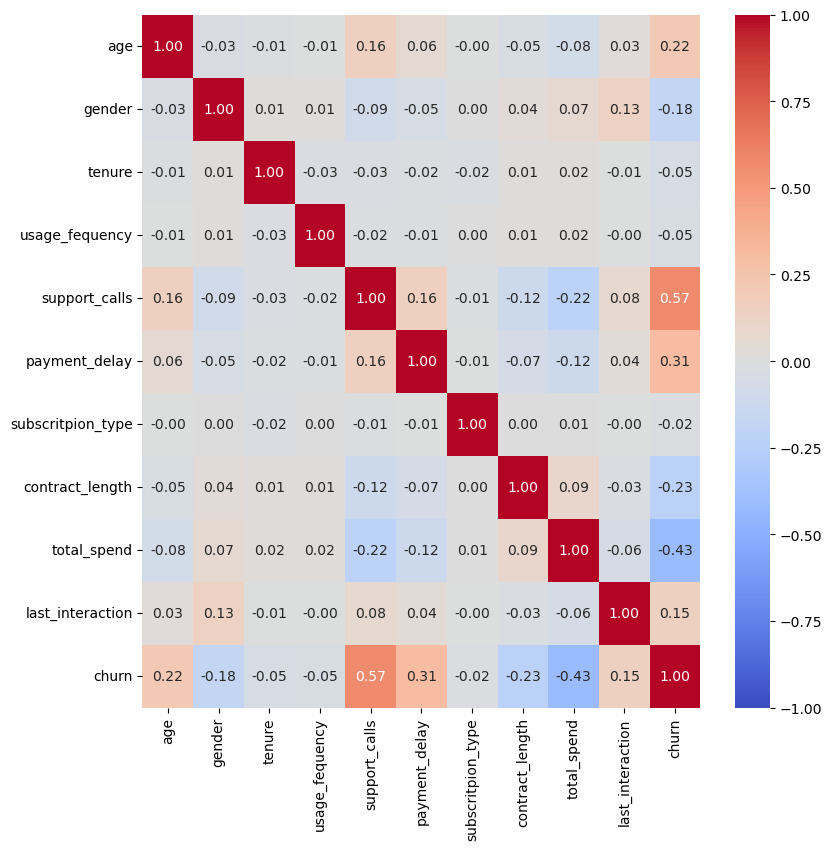

In [86]:
plt.figure(figsize=(9,9))
sns.heatmap(df_train.corr(), vmin=-1, annot=True, cmap='coolwarm', fmt='.2f')

In [115]:
df_train.columns

Index(['age', 'gender', 'tenure', 'usage_frequency', 'support_calls',
       'payment_delay', 'subscription_type', 'contract_length', 'total_spend',
       'last_interaction', 'churn'],
      dtype='object')

In [99]:
# training data setting fitting variables and predictor
X_train = df_train[['age', 'gender', 'tenure', 'usage_frequency', 'support_calls',
       'payment_delay', 'subscription_type', 'contract_length', 'total_spend',
       'last_interaction']]
y_train = df_train['churn']

# test data setting fitting variables and predictor
X_test = df_test[['age', 'gender', 'tenure', 'usage_frequency', 'support_calls',
       'payment_delay', 'subscription_type', 'contract_length', 'total_spend',
       'last_interaction']]
y_test = df_test['churn']

In [100]:
logres_model = LogisticRegression(max_iter=10000)
logres_model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [101]:
#train_pred = logres_model.predict(X_train)
test_pred = logres_model.predict(X_test)

#train_prob = logres_model.predict_proba(X_train)[:, 1]
test_prob = logres_model.predict_proba(X_test)[:, 1]

In [102]:
#train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)

#train_accuracy_report = classification_report(y_train, train_pred)
test_accuracy_report = classification_report(y_test, test_pred)

#train_accuracy_roc_auc = roc_auc_score(y_train, train_pred)
test_accuracy_roc_auc = roc_auc_score(y_test, test_pred)

In [103]:
print('--------accuracy---------')
#print(f'1. Training Accuracy Score: {train_accuracy:.2f}')
print(f'2. Testing Accuracy Score: {test_accuracy:.2f}')
print('--------classification reports---------')
#print(f'1. Training Classification Report :\n {train_accuracy_report}')
print(f'2. Testing Classification Report :\n {test_accuracy_report}')
print('--------roc_auc---------')
#print(f'1. Training roc_auc Score :\n {train_accuracy_roc_auc}')
print(f'2. testing roc_auc score :\n {test_accuracy_roc_auc}')

--------accuracy---------
2. Testing Accuracy Score: 0.58
--------classification reports---------
2. Testing Classification Report :
               precision    recall  f1-score   support

           0       0.95      0.22      0.36     33881
           1       0.53      0.99      0.69     30493

    accuracy                           0.58     64374
   macro avg       0.74      0.60      0.53     64374
weighted avg       0.75      0.58      0.52     64374

--------roc_auc---------
2. testing roc_auc score :
 0.6045423916256509


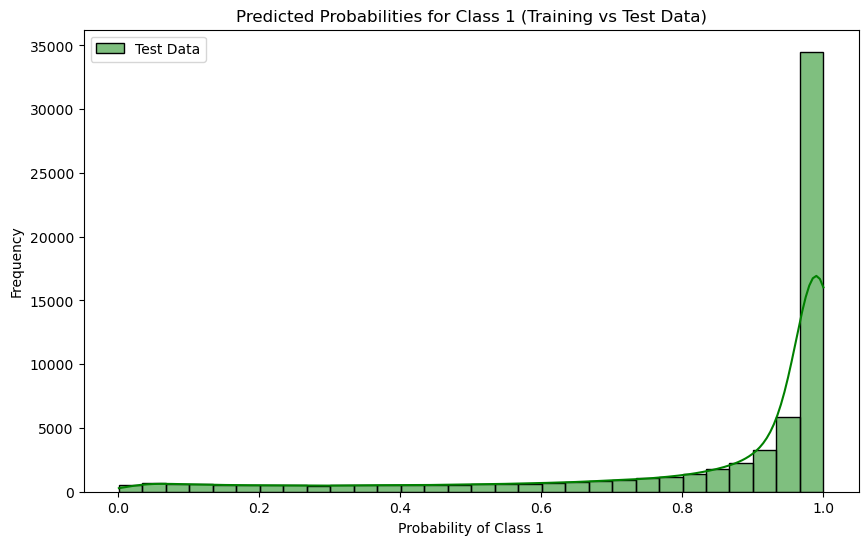

In [104]:
# Plot histograms
plt.figure(figsize=(10, 6))
#sns.histplot(train_prob, kde=True, color='blue', label='Training Data', bins=30)
sns.histplot(test_prob, kde=True, color='green', label='Test Data', bins=30)
plt.title('Predicted Probabilities for Class 1 (Training vs Test Data)')
plt.xlabel('Probability of Class 1')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [105]:
# Inspect the coefficients
coeffs = logres_model.coef_[0]
feature_names = X_test.columns
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coeffs})
print(feature_importance.sort_values(by='Coefficient', ascending=False))


             Feature  Coefficient
4      support_calls     0.686506
5      payment_delay     0.102786
9   last_interaction     0.055269
0                age     0.034418
8        total_spend    -0.005465
2             tenure    -0.007029
3    usage_frequency    -0.013616
6  subscription_type    -0.058272
7    contract_length    -0.117399
1             gender    -1.061013


## pipeline for params

In [106]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

In [107]:
pipe = Pipeline([
    ('scaler',  StandardScaler()),
    ('poly_feat', PolynomialFeatures(degree=2)),
    ('log_reg',  LogisticRegression(max_iter=10000))
])

params = {
    'poly_feat__degree' : [1, 2],
    'log_reg__C' : np.logspace(-2, 0, num=3),
    'log_reg__solver' : ['liblinear']
}

random_search = RandomizedSearchCV(
    pipe, param_distributions=params, cv=4, n_iter=4, scoring='roc_auc', random_state=42, verbose=2
)

random_search.fit(X_train, y_train)

print('Best Params: \n', random_search.best_params_)
print('Best Score (roc_auc): \n', random_search.best_score_)
print('Best Estimator: \n ', random_search.best_estimator_)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV] END log_reg__C=0.01, log_reg__solver=liblinear, poly_feat__degree=1; total time=   0.3s
[CV] END log_reg__C=0.01, log_reg__solver=liblinear, poly_feat__degree=1; total time=   0.4s
[CV] END log_reg__C=0.01, log_reg__solver=liblinear, poly_feat__degree=1; total time=   0.4s
[CV] END log_reg__C=0.01, log_reg__solver=liblinear, poly_feat__degree=1; total time=   0.3s
[CV] END log_reg__C=0.01, log_reg__solver=liblinear, poly_feat__degree=2; total time=   2.8s
[CV] END log_reg__C=0.01, log_reg__solver=liblinear, poly_feat__degree=2; total time=   2.9s
[CV] END log_reg__C=0.01, log_reg__solver=liblinear, poly_feat__degree=2; total time=   3.1s
[CV] END log_reg__C=0.01, log_reg__solver=liblinear, poly_feat__degree=2; total time=   3.1s
[CV] END log_reg__C=1.0, log_reg__solver=liblinear, poly_feat__degree=2; total time=   5.0s
[CV] END log_reg__C=1.0, log_reg__solver=liblinear, poly_feat__degree=2; total time=   4.8s
[CV] END log

In [108]:
best_log_reg = random_search.best_estimator_
hyper_param_test_pred = best_log_reg.predict(X_test)

In [124]:
test_proba = best_log_reg.predict_proba(X_test)[:, 1]
print(test_proba)

[1.         1.         0.95769856 ... 1.         1.         1.        ]


In [128]:
hyper_param_test_accuracy = accuracy_score(y_test, hyper_param_test_pred)

hyper_param_test_accuracy_report = classification_report(y_test, hyper_param_test_pred)

hyper_param_test_accuracy_roc_auc = roc_auc_score(y_test, hyper_param_test_pred)

hyper_param_test_confusion_matrix = confusion_matrix(y_test, hyper_param_test_pred)

In [129]:
print('--------hyper_param_accuracy---------')
print(f'1. HyperParam Testing Accuracy Score: \n  {hyper_param_test_accuracy:.2f}')
print('--------hyper_paramclassification_report---------')
print(f'2. HyperParam Testing Classification Report :\n {hyper_param_test_accuracy_report}')
print('--------hyper_param_roc_auc---------')
print(f'3. HyperParam Testing roc_auc score :\n {hyper_param_test_accuracy_roc_auc}')
print('--------confusion_matrix---------')
print(f'3. HyperParam Testing Confusion Matrix :\n {hyper_param_test_confusion_matrix}')

--------hyper_param_accuracy---------
1. HyperParam Testing Accuracy Score: 
  0.53
--------hyper_paramclassification_report---------
2. HyperParam Testing Classification Report :
               precision    recall  f1-score   support

           0       0.97      0.11      0.19     33881
           1       0.50      1.00      0.67     30493

    accuracy                           0.53     64374
   macro avg       0.74      0.55      0.43     64374
weighted avg       0.75      0.53      0.42     64374

--------hyper_param_roc_auc---------
3. HyperParam Testing roc_auc score :
 0.5518596189752402
--------confusion_matrix---------
3. HyperParam Testing Confusion Matrix :
 [[ 3633 30248]
 [  107 30386]]


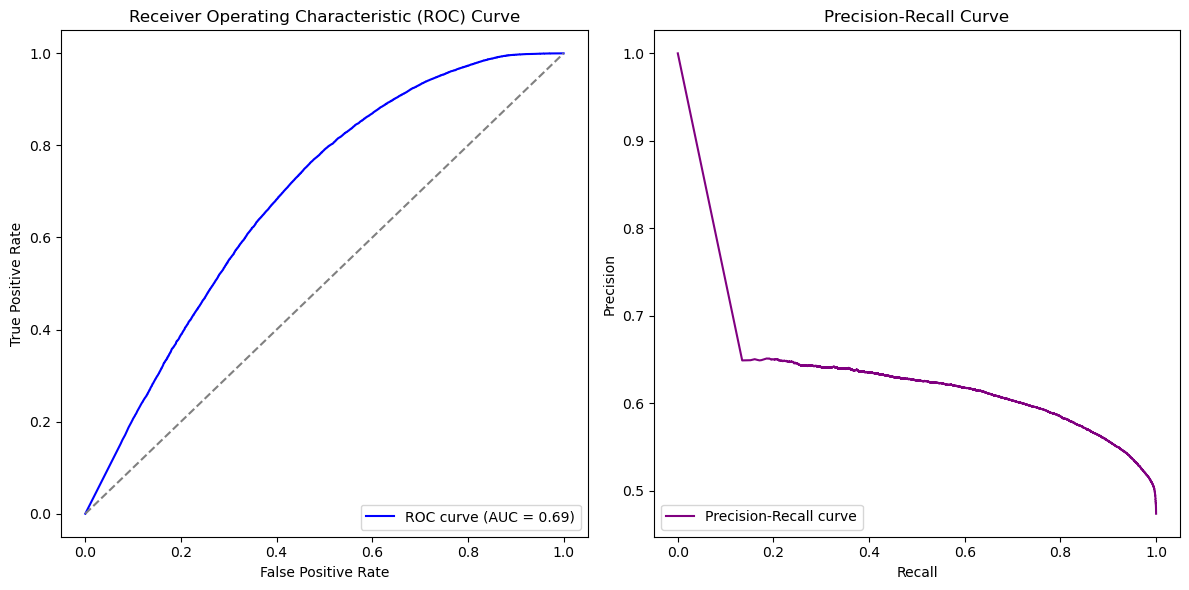

In [125]:
# Plot ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_test, test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 6))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random model line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot Precision-Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, test_proba)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='purple', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

In [114]:
import pickle

# Save the best model
# Save the best model
with open('../../models/trained_model_01_logreg.pkl', 'wb') as f:
    pickle.dump(best_log_reg, f)

# Load the saved model
#with open('trained_model_01_LogReg.pkl', 'rb') as f:
#    best_log_reg_loaded = pickle.load(f)
